In [ ]:
GROQ_API_KEY = "GROQ_API_KEY"
SERP_API_KEY = "SERP_API_KEY"
ANTHROPY_API_KEY = "ANTHROPY_API_KEY"

## Simple Chatbot

In [ ]:
from langchain_groq import ChatGroq

In [ ]:
# Initialize LLM (replace with your preferred model)
llm = ChatGroq(
    temperature=0,
    model_name="llama-3.3-70b-versatile",
    api_key=GROQ_API_KEY
)

In [4]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

In [5]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}
# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.

In [6]:
graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)

In [7]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)
graph = graph_builder.compile()

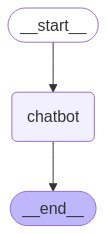

In [8]:
from IPython.display import Image, display, Markdown

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    mermaid_code = graph.get_graph().draw_mermaid()
    display(Markdown(f"```mermaid\n{mermaid_code}\n```"))

In [9]:
def stream_graph_updates(user_input: str):
    print("User: " + user_input)
    print("--" * 50)
    # This will print the graph updates as they happen
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        print(event)
        print("--" * 50)
        for key, value in event.items():
            print(f"{key}:", value["messages"][-1].content)

In [10]:
user_input = "Hi, I am Saurabh."
stream_graph_updates(user_input)

User: Hi, I am Saurabh.
----------------------------------------------------------------------------------------------------
{'chatbot': {'messages': [AIMessage(content="Hello Saurabh, it's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 43, 'total_tokens': 71, 'completion_time': 0.101818182, 'prompt_time': 0.002390045, 'queue_time': 0.061070970999999995, 'total_time': 0.104208227}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_9a8b91ba77', 'finish_reason': 'stop', 'logprobs': None}, id='run-4cc9ca5d-6158-4653-95d8-451945a9daf1-0', usage_metadata={'input_tokens': 43, 'output_tokens': 28, 'total_tokens': 71})]}}
----------------------------------------------------------------------------------------------------
chatbot: Hello Saurabh, it's nice to meet you. Is there something I can help you with or would you like to chat?


## Enhancing the Chatbot with Search Tools

In [108]:
import requests
import json
from langchain_core.messages import ToolMessage
from langchain_core.prompts import PromptTemplate
from datetime import datetime

In [ ]:
# ================== Internet Search Agent ==================
class InternetSearchAgent:
    def __init__(self):
        self.url = "https://google.serper.dev/search"
        self.headers = {
        'X-API-KEY': SERP_API_KEY,
        'Content-Type': 'application/json'
        }
        self.history = []

    def search_web(self, query):
        """Perform web search with error handling"""
        try:
            payload = json.dumps({
                "q": query,
                "location": "India",
                "gl": "in"
            })
            response = requests.post(self.url, headers=self.headers, data=payload, timeout=10)
            response.raise_for_status()
            
            result = response.json()
            self.history.append({"query": query, "result": result})
            
            # Extract and format relevant information
            if 'organic' not in result:
                return "No relevant web results found."
                
            top_results = result['organic'][:3]
            return "\n".join([f"{res['title']}: {res.get('snippet', '')}" for res in top_results])
            
        except Exception as e:
            return f"Search error: {str(e)}"


In [13]:
from langchain.tools import Tool  # Import Tool class
internet_agent = InternetSearchAgent()
internet_search_tool = Tool(
    name="InternetSearch",
    func=internet_agent.search_web,
    description="Searches the internet for current information and general knowledge. Input should be a search query string."
)
# Define tools with proper formatting
tools = [
    internet_search_tool,
]

In [15]:
internet_search_tool.invoke("What's a 'node' in LangGraph?")

"LangGraph Glossary - GitHub Pages: Nodes : Python functions that encode the logic of your agents. They receive the current State as input, perform some computation or side-effect, and return an ...\nLangGraph - LangChain Blog: ... node that is used to represent the end of the graph. It is important that your cycles be able to end eventually! from langgraph.graph import END ...\nBeginner's Guide to LangGraph: Understanding State, Nodes, and ...: Each node represents a specific function or operation that processes the current state. Nodes can perform computations, modify the state, or ..."

In [191]:
# Initialize LLM (replace with your preferred model)
llm = ChatGroq(
    temperature=0,
    # model_name="llama3-70b-8192",
    model_name="llama-3.1-8b-instant",
    api_key=GROQ_API_KEY
)
# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)

In [192]:
# ================== State Definitions ==================
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [193]:
tools_by_name = {tool.name: tool for tool in tools}
tools_by_name

{'InternetSearch': Tool(name='InternetSearch', description='Searches the internet for current information and general knowledge. Input should be a search query string.', func=<bound method InternetSearchAgent.search_web of <__main__.InternetSearchAgent object at 0x000002E1F2C55ED0>>)}

State:  {'messages': [

    HumanMessage(content='Hi, I am Saurabh.', additional_kwargs={}, response_metadata={}, id='36f8373d-a4d2-4b28-8195-75eef34bfeb9'),

    AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_k7wv', 'function': {'arguments': '{"__arg1":"Saurabh"}', 'name': 'InternetSearch'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 47, 'prompt_tokens': 931, 'total_tokens': 978, 'completion_time': 0.134285714, 'prompt_time': 0.038009731, 'queue_time': 0.054636106999999996, 'total_time': 0.172295445}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_dd4ae1c591', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-2d687b0f-36f1-48e7-a83f-fe28f38efa88-0', tool_calls=[{'name': 'InternetSearch', 'args': {'__arg1': 'Saurabh'}, 'id': 'call_k7wv', 'type': 'tool_call'}], usage_metadata={'input_tokens': 931, 'output_tokens': 47, 'total_tokens': 978}),
    
    ToolMessage(content='"Saurabh Tiwary - Wikipedia: Saurabh Tiwary (born 30 December 1989) is an Indian former cricketer who played as a left-handed middle order batsman. He was one of the key batsmen in the ...\\nSaurabh Tiwary Profile - Cricket Player India | Stats, Records, Video: Saurabh Tiwary, a left-handed batsman who began playing cricket at the age of 11, represented Jharkhand at the Under-14 level before making his first-class ...\\nSaurabh Tiwary (@iamstiwary) \\u2022 Instagram photos and videos: Cricketer. Jharkhand @mumbaiindians \\u00b7 Photo by Saurabh Tiwary on April 13, 2016. Blessed to share the dugout area with these stalwarts of the game. \\u00b7 Photo by ..."', name='InternetSearch', id='60a8af3f-bda0-4664-9c20-778a9c074572', tool_call_id='call_k7wv')
    
    ]}

In [194]:
# ================== Node Definitions ==================
def chatbot(state: State):
    # print("State: ", state)
    return {"messages": [llm_with_tools.invoke(state["messages"])]}
    # Define the prompt template
    prompt = PromptTemplate(
        template="""You are a helpful AI assistant with access to internet search. 
        Current date: {current_date}
        
        Use internet search when:
        1. Asked about recent events or news
        2. Questions require up-to-date information (after your knowledge cutoff)
        3. You need factual data that may not be in your training
        4. User asks for latest research, statistics, or developments
        
        Guidelines:
        - First determine if the question requires current information
        - If needed, call the search tool with a concise yet specific query
        - Always maintain helpful, conversational tone
        
        Question: {question}
        """,
        input_variables=["question", "current_date"],
    )
    
    # Get the conversation history and latest question
    messages = state["messages"][-1].content
    
    # Create and invoke the chain
    chain = prompt | llm_with_tools
    result = chain.invoke({
        "question": messages,
        "current_date": datetime.now().strftime("%Y-%m-%d")
    })
    return {"messages": [result]}

class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}
tool_node = BasicToolNode(tools=tools)

In [195]:
# ================== Conditional Edge ==================
def route_tools(state: State,):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    # print("AI Message:", ai_message)
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END

In [196]:
#  ================== Graph Definition ==================
graph_builder = StateGraph(State)
# Add the nodes to the graph
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)


In [197]:
# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)

In [198]:
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("tools", "chatbot")

In [199]:
graph = graph_builder.compile()

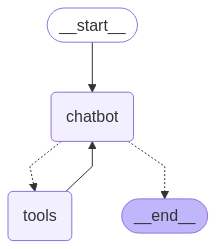

In [200]:
from IPython.display import Image, display, Markdown

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    mermaid_code = graph.get_graph().draw_mermaid()
    display(Markdown(f"```mermaid\n{mermaid_code}\n```"))

In [201]:
def stream_graph_updates(user_input: str):
    # print("User: " + user_input)
    print("==" * 50)
    # This will print the graph updates as they happen
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        print("--" * 50)
        print(event)
        for key, value in event.items():
            # print(f"{key}:", value["messages"][-1].content)
            value["messages"][-1].pretty_print()
        ai_output = value["messages"][-1].content
    print("================================== AskAI ==================================")
    print("User:", user_input)
    print("AskAI:", ai_output)

In [202]:
user_input = "Hi, I am Saurabh."
stream_graph_updates(user_input)

----------------------------------------------------------------------------------------------------
{'chatbot': {'messages': [AIMessage(content='Hello Saurabh, how can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 254, 'total_tokens': 267, 'completion_time': 0.017333333, 'prompt_time': 0.035331784, 'queue_time': 0.051672435999999995, 'total_time': 0.052665117}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_a4265e44d5', 'finish_reason': 'stop', 'logprobs': None}, id='run-86b04e68-e927-4794-9e09-e62bc7bf1a5d-0', usage_metadata={'input_tokens': 254, 'output_tokens': 13, 'total_tokens': 267})]}}
================================== Ai Message ==================================

Hello Saurabh, how can I assist you today?
================================== AskAI ==================================
User: Hi, I am Saurabh.
AskAI: Hello Saurabh, how can I assist you today?


In [203]:
user_input = "What is the weather in Bangalore."
stream_graph_updates(user_input)

----------------------------------------------------------------------------------------------------
{'chatbot': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_aeve', 'function': {'arguments': '{"__arg1": "Bangalore weather today"}', 'name': 'InternetSearch'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 253, 'total_tokens': 273, 'completion_time': 0.026666667, 'prompt_time': 0.047525174, 'queue_time': 0.047611376, 'total_time': 0.074191841}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_a4265e44d5', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-462c9e05-4795-40ed-9f07-dad124eea546-0', tool_calls=[{'name': 'InternetSearch', 'args': {'__arg1': 'Bangalore weather today'}, 'id': 'call_aeve', 'type': 'tool_call'}], usage_metadata={'input_tokens': 253, 'output_tokens': 20, 'total_tokens': 273})]}}
================================== Ai Message =============================

## Adding Memory to the Chatbot

In [204]:
import requests
import json
from langchain_core.messages import ToolMessage
from langchain_core.prompts import PromptTemplate
from datetime import datetime

In [205]:
# ================== Internet Search Agent ==================
class InternetSearchAgent:
    def __init__(self):
        self.url = "https://google.serper.dev/search"
        self.headers = {
        'X-API-KEY': SERP_API_KEY,
        'Content-Type': 'application/json'
        }
        self.history = []

    def search_web(self, query):
        """Perform web search with error handling"""
        try:
            payload = json.dumps({
                "q": query,
                "location": "India",
                "gl": "in"
            })
            response = requests.post(self.url, headers=self.headers, data=payload, timeout=10)
            response.raise_for_status()
            
            result = response.json()
            self.history.append({"query": query, "result": result})
            
            # Extract and format relevant information
            if 'organic' not in result:
                return "No relevant web results found."
                
            top_results = result['organic'][:3]
            return "\n".join([f"{res['title']}: {res.get('snippet', '')}" for res in top_results])
            
        except Exception as e:
            return f"Search error: {str(e)}"


In [206]:
from langchain.tools import Tool  # Import Tool class
internet_agent = InternetSearchAgent()
internet_search_tool = Tool(
    name="InternetSearch",
    func=internet_agent.search_web,
    description="Searches the internet for current information and general knowledge. Input should be a search query string."
)
# Define tools with proper formatting
tools = [
    internet_search_tool,
]

In [207]:
internet_search_tool.invoke("What's a 'node' in LangGraph?")

"LangGraph Glossary - GitHub Pages: Nodes : Python functions that encode the logic of your agents. They receive the current State as input, perform some computation or side-effect, and return an ...\nLangGraph - LangChain Blog: ... node that is used to represent the end of the graph. It is important that your cycles be able to end eventually! from langgraph.graph import END ...\nBeginner's Guide to LangGraph: Understanding State, Nodes, and ...: Each node represents a specific function or operation that processes the current state. Nodes can perform computations, modify the state, or ..."

In [240]:
# Initialize LLM (replace with your preferred model)
llm = ChatGroq(
    temperature=0,
    # model_name="llama3-70b-8192",
    model_name="llama-3.1-8b-instant",
    api_key=GROQ_API_KEY
)
# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)

In [241]:
# ================== State Definitions ==================
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [242]:
# ================== Node Definitions ==================
def chatbot(state: State):
    # print("State: ", state)
    return {"messages": [llm_with_tools.invoke(state["messages"])]}
    # Define the prompt template
    prompt = PromptTemplate(
        template="""You are a helpful AI assistant with access to internet search. 
        Current date: {current_date}
        
        Use internet search when:
        1. Asked about recent events or news
        2. Questions require up-to-date information (after your knowledge cutoff)
        3. You need factual data that may not be in your training
        4. User asks for latest research, statistics, or developments
        
        Guidelines:
        - First determine if the question requires current information
        - If needed, call the search tool with a concise yet specific query
        - Always maintain helpful, conversational tone
        
        Question: {question}
        """,
        input_variables=["question", "current_date"],
    )
    
    # Get the conversation history and latest question
    messages = state["messages"][-1].content
    
    # Create and invoke the chain
    chain = prompt | llm_with_tools
    result = chain.invoke({
        "question": messages,
        "current_date": datetime.now().strftime("%Y-%m-%d")
    })
    return {"messages": [result]}

class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}
tool_node = BasicToolNode(tools=tools)

In [243]:
# ================== Conditional Edge ==================
def route_tools(state: State,):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    # print("AI Message:", ai_message)
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END

In [244]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [245]:
#  ================== Graph Definition ==================
graph_builder = StateGraph(State)
# Add the nodes to the graph
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)


In [246]:
# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)

In [247]:
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("tools", "chatbot")

In [248]:
graph = graph_builder.compile(checkpointer=memory)

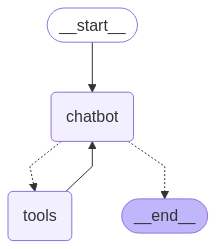

In [249]:
from IPython.display import Image, display, Markdown

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    mermaid_code = graph.get_graph().draw_mermaid()
    display(Markdown(f"```mermaid\n{mermaid_code}\n```"))

In [250]:
config = {"configurable": {"thread_id": "1"}}

In [251]:
def stream_graph_updates(user_input: str):
    # print("User: " + user_input)
    print("==" * 50)
    # This will print the graph updates as they happen
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}, config):
        print("--" * 50)
        print(event)
        for key, value in event.items():
            # print(f"{key}:", value["messages"][-1].content)
            value["messages"][-1].pretty_print()
        ai_output = value["messages"][-1].content
    print("================================== AskAI ==================================")
    print("User:", user_input)
    print("AskAI:", ai_output)

In [252]:
user_input = "Hi, I am Saurabh."
stream_graph_updates(user_input)

----------------------------------------------------------------------------------------------------
{'chatbot': {'messages': [AIMessage(content='Hello Saurabh, how can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 254, 'total_tokens': 267, 'completion_time': 0.017333333, 'prompt_time': 0.047622217, 'queue_time': 0.954682987, 'total_time': 0.06495555}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_8d1c73bd4c', 'finish_reason': 'stop', 'logprobs': None}, id='run-7160f215-36c5-4871-97a9-98a7db1eebb1-0', usage_metadata={'input_tokens': 254, 'output_tokens': 13, 'total_tokens': 267})]}}
================================== Ai Message ==================================

Hello Saurabh, how can I assist you today?
================================== AskAI ==================================
User: Hi, I am Saurabh.
AskAI: Hello Saurabh, how can I assist you today?


In [253]:
user_input = "I live in Bangalore. Can you tell me the weather there?"
stream_graph_updates(user_input)

----------------------------------------------------------------------------------------------------
{'chatbot': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_da0t', 'function': {'arguments': '{"search query string": "Bangalore weather today"}', 'name': 'InternetSearch'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 289, 'total_tokens': 309, 'completion_time': 0.026666667, 'prompt_time': 0.027869836, 'queue_time': 0.046563859, 'total_time': 0.054536503}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_a56f6eea01', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-2ebf192c-6e11-4889-abbd-b4bc245c3996-0', tool_calls=[{'name': 'InternetSearch', 'args': {'search query string': 'Bangalore weather today'}, 'id': 'call_da0t', 'type': 'tool_call'}], usage_metadata={'input_tokens': 289, 'output_tokens': 20, 'total_tokens': 309})]}}
================================== Ai Message ===

In [254]:
user_input = "Remember my name and where I live?"
stream_graph_updates(user_input)

----------------------------------------------------------------------------------------------------
{'chatbot': {'messages': [AIMessage(content='I remember, your name is Saurabh and you live in Bangalore.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 622, 'total_tokens': 638, 'completion_time': 0.021333333, 'prompt_time': 0.029782457, 'queue_time': 0.070348577, 'total_time': 0.05111579}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_8d1c73bd4c', 'finish_reason': 'stop', 'logprobs': None}, id='run-5c2283cb-d3ae-48e7-afab-eb3fac8c8fe4-0', usage_metadata={'input_tokens': 622, 'output_tokens': 16, 'total_tokens': 638})]}}
================================== Ai Message ==================================

I remember, your name is Saurabh and you live in Bangalore.
================================== AskAI ==================================
User: Remember my name and where I live?
AskAI: I remember, your name is Saurabh a

In [255]:
config = {"configurable": {"thread_id": "2"}}

In [256]:
user_input = "Remember my name and where I live?"
stream_graph_updates(user_input)

----------------------------------------------------------------------------------------------------
{'chatbot': {'messages': [AIMessage(content="I don't have personal memories or the ability to store information about individual users. Each time you interact with me, it's a new conversation and I don't retain any information from previous conversations.", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 40, 'prompt_tokens': 254, 'total_tokens': 294, 'completion_time': 0.053333333, 'prompt_time': 0.012486247, 'queue_time': 0.045929409000000004, 'total_time': 0.06581958}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_a56f6eea01', 'finish_reason': 'stop', 'logprobs': None}, id='run-0d13227f-a47a-4aa8-8227-26a236c14f1e-0', usage_metadata={'input_tokens': 254, 'output_tokens': 40, 'total_tokens': 294})]}}
================================== Ai Message ==================================

I don't have personal memories or the ability to store inf

In [259]:
config = {"configurable": {"thread_id": "1"}}
state = graph.get_state(config=config)
print(state)

StateSnapshot(values={'messages': [HumanMessage(content='Hi, I am Saurabh.', additional_kwargs={}, response_metadata={}, id='fd195913-4ca4-4fa4-8979-85d57b805743'), AIMessage(content='Hello Saurabh, how can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 254, 'total_tokens': 267, 'completion_time': 0.017333333, 'prompt_time': 0.047622217, 'queue_time': 0.954682987, 'total_time': 0.06495555}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_8d1c73bd4c', 'finish_reason': 'stop', 'logprobs': None}, id='run-7160f215-36c5-4871-97a9-98a7db1eebb1-0', usage_metadata={'input_tokens': 254, 'output_tokens': 13, 'total_tokens': 267}), HumanMessage(content='I live in Bangalore. Can you tell me the weather there?', additional_kwargs={}, response_metadata={}, id='f58fd5f4-7b85-4ba7-885e-680f835685d1'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_da0t', 'function': {'arguments': '{"search q

StateSnapshot(values={'messages': 

[HumanMessage(content='Hi, I am Saurabh.', additional_kwargs={}, response_metadata={}, id='fd195913-4ca4-4fa4-8979-85d57b805743'), 

AIMessage(content='Hello Saurabh, how can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 254, 'total_tokens': 267, 'completion_time': 0.017333333, 'prompt_time': 0.047622217, 'queue_time': 0.954682987, 'total_time': 0.06495555}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_8d1c73bd4c', 'finish_reason': 'stop', 'logprobs': None}, id='run-7160f215-36c5-4871-97a9-98a7db1eebb1-0', usage_metadata={'input_tokens': 254, 'output_tokens': 13, 'total_tokens': 267}),

HumanMessage(content='I live in Bangalore. Can you tell me the weather there?', additional_kwargs={}, response_metadata={}, id='f58fd5f4-7b85-4ba7-885e-680f835685d1'), 

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_da0t', 'function': {'arguments': '{"search query string": "Bangalore weather today"}', 'name': 'InternetSearch'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 289, 'total_tokens': 309, 'completion_time': 0.026666667, 'prompt_time': 0.027869836, 'queue_time': 0.046563859, 'total_time': 0.054536503}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_a56f6eea01', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-2ebf192c-6e11-4889-abbd-b4bc245c3996-0', tool_calls=[{'name': 'InternetSearch', 'args': {'search query string': 'Bangalore weather today'}, 'id': 'call_da0t', 'type': 'tool_call'}], usage_metadata={'input_tokens': 289, 'output_tokens': 20, 'total_tokens': 309}), 

ToolMessage(content='"Bengaluru, Karnataka, India Weather Forecast - AccuWeather: Hourly Weather \\u00b7 1 AM 78\\u00b0. rain drop 1% \\u00b7 2 AM 77\\u00b0. rain drop 1% \\u00b7 3 AM 76\\u00b0. rain drop 1% \\u00b7 4 AM 75\\u00b0. rain drop 1% \\u00b7 5 AM 75\\u00b0. rain drop 1% \\u00b7 6 AM 74\\u00b0. rain drop 1%.\\nReal-Time Bangalore Weather Conditions & Forecast - AQI: Current Bangalore weather condition is Partly cloudy with real-time temperature (27\\u00b0C), humidity 62%, wind 25.9km/h, pressure (1015mb), UV (0), ...\\nBengaluru-City - Local Weather Report and Forecast: Date, Min Temp, Max Temp, Weather ; 27-Apr, 23.0, 34.0, Partly cloudy sky with one or two spells of rain or thundershowers."', name='InternetSearch', id='c0469412-c904-4a74-bff3-0cfa28f877db', tool_call_id='call_da0t'), 

AIMessage(content='It seems like the weather in Bangalore is partly cloudy with a temperature of around 27°C and a humidity of 62%. There might be some rain or thundershowers.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 37, 'prompt_tokens': 568, 'total_tokens': 605, 'completion_time': 0.049333333, 'prompt_time': 0.106139323, 'queue_time': 0.266735832, 'total_time': 0.155472656}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_8d1c73bd4c', 'finish_reason': 'stop', 'logprobs': None}, id='run-17851cd0-4277-4bde-aa5a-dac19aadfc8b-0', usage_metadata={'input_tokens': 568, 'output_tokens': 37, 'total_tokens': 605}), 

HumanMessage(content='Remember my name and where I live?', additional_kwargs={}, response_metadata={}, id='44575a7b-21c0-4a7a-bf57-832ec5d49af6'), 

AIMessage(content='I remember, your name is Saurabh and you live in Bangalore.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 622, 'total_tokens': 638, 'completion_time': 0.021333333, 'prompt_time': 0.029782457, 'queue_time': 0.070348577, 'total_time': 0.05111579}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_8d1c73bd4c', 'finish_reason': 'stop', 'logprobs': None}, id='run-5c2283cb-d3ae-48e7-afab-eb3fac8c8fe4-0', usage_metadata={'input_tokens': 622, 'output_tokens': 16, 'total_tokens': 638})]}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0239c9-ba51-6317-8009-677819bbda50'}}, metadata={'source': 'loop', 'writes': {'chatbot': {'messages': [AIMessage(content='I remember, your name is Saurabh and you live in Bangalore.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 622, 'total_tokens': 638, 'completion_time': 0.021333333, 'prompt_time': 0.029782457, 'queue_time': 0.070348577, 'total_time': 0.05111579}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_8d1c73bd4c', 'finish_reason': 'stop', 'logprobs': None}, id='run-5c2283cb-d3ae-48e7-afab-eb3fac8c8fe4-0', usage_metadata={'input_tokens': 622, 'output_tokens': 16, 'total_tokens': 638})]}}, 'step': 9, 'parents': {}, 'thread_id': '1'}, created_at='2025-04-27T19:19:58.164251+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0239c9-b812-610d-8008-c9eb10785de3'}}, tasks=())

In [260]:
config = {"configurable": {"thread_id": "1"}}
state_history = graph.get_state_history(config)
for state in state_history:
    print(state)

StateSnapshot(values={'messages': [HumanMessage(content='Hi, I am Saurabh.', additional_kwargs={}, response_metadata={}, id='fd195913-4ca4-4fa4-8979-85d57b805743'), AIMessage(content='Hello Saurabh, how can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 254, 'total_tokens': 267, 'completion_time': 0.017333333, 'prompt_time': 0.047622217, 'queue_time': 0.954682987, 'total_time': 0.06495555}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_8d1c73bd4c', 'finish_reason': 'stop', 'logprobs': None}, id='run-7160f215-36c5-4871-97a9-98a7db1eebb1-0', usage_metadata={'input_tokens': 254, 'output_tokens': 13, 'total_tokens': 267}), HumanMessage(content='I live in Bangalore. Can you tell me the weather there?', additional_kwargs={}, response_metadata={}, id='f58fd5f4-7b85-4ba7-885e-680f835685d1'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_da0t', 'function': {'arguments': '{"search q

## Human-in-the-loop

In [38]:
from typing import Annotated
import json
import requests
from langchain.chat_models import init_chat_model
from langchain_core.tools import tool
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langgraph.types import Command, interrupt
from langchain.tools import Tool  # Import Tool class

In [39]:
# ================== Internet Search Agent ==================
class InternetSearchAgent:
    def __init__(self):
        self.url = "https://google.serper.dev/search"
        self.headers = {
        'X-API-KEY': SERP_API_KEY,
        'Content-Type': 'application/json'
        }
        self.history = []

    def search_web(self, query):
        """Perform web search with error handling"""
        try:
            payload = json.dumps({
                "q": query,
                "location": "India",
                "gl": "in"
            })
            response = requests.post(self.url, headers=self.headers, data=payload, timeout=10)
            response.raise_for_status()
            
            result = response.json()
            self.history.append({"query": query, "result": result})
            
            # Extract and format relevant information
            if 'organic' not in result:
                return "No relevant web results found."
                
            top_results = result['organic'][:3]
            return "\n".join([f"{res['title']}: {res.get('snippet', '')}" for res in top_results])
            
        except Exception as e:
            return f"Search error: {str(e)}"
        
internet_agent = InternetSearchAgent()
internet_search_tool = Tool(
    name="InternetSearch",
    func=internet_agent.search_web,
    description="Searches the internet for current information and general knowledge. Input should be a search query string."
)


In [40]:
@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]


tools = [internet_search_tool, human_assistance]

# Initialize LLM (replace with your preferred model)
llm = ChatGroq(
    temperature=0,
    # model_name="llama3-70b-8192",
    model_name="llama-3.1-8b-instant",
    api_key=GROQ_API_KEY
)
# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)

In [41]:
# ================== State Definitions ==================
class State(TypedDict):
    messages: Annotated[list, add_messages]

# ================== Graph Build ==================
graph_builder = StateGraph(State)

In [42]:
# ================== Node Definitions ==================
def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}

tool_node = ToolNode(tools=tools)


# ================== Add Node ==================
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)

# ================== Conditional Edge ==================
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [43]:
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

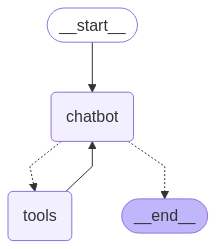

In [44]:
from IPython.display import Image, display, Markdown

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    mermaid_code = graph.get_graph().draw_mermaid()
    display(Markdown(f"```mermaid\n{mermaid_code}\n```"))

In [49]:
user_input = "I need some expert guidance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_vnd3)
 Call ID: call_vnd3
  Args:
    query: expert guidance for building an AI agent


In [50]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

In [ ]:
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)

human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

## Customizing State